In [1]:
!pwd

/reg/data/ana03/scratch/cwang31/pf


In [2]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [3]:
import os
import torch
import random
import numpy as np
import h5py
import time

from peaknet.methods.att_unet   import AttentionUNet
from peaknet.model              import ConfigPeakFinderModel, PeakFinderModel
from peaknet.datasets.utils     import PsanaImg
from peaknet.datasets.transform import center_crop, coord_crop_to_img

from cupyx.scipy import ndimage
import cupy as cp

seed = 0

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
%matplotlib inline

## Load psana for accessing image data

In [5]:
# Sample cspad dataset
exp           = 'cxic0415'
run           = 101
img_load_mode = 'calib'
access_mode   = 'idx'
detector_name = 'CxiDs1.0:Cspad.0'
photon_energy = 12688.890590380644    # eV
encoder_value = -450.0034

psana_img = PsanaImg(exp, run, access_mode, detector_name)

In [ ]:
# # Sample epix10k dataset
# exp           = 'mfxp22820'
# run           = 13
# img_load_mode = 'calib'
# access_mode   = 'idx'
# detector_name = 'Rayonix'
# photon_energy = 9.54e3    # eV
# encoder_value = -196

# psana_img = PsanaImg(exp, run, access_mode, detector_name)

## Load Model

In [6]:
timestamp = "2023_0404_1645_58"    # lam = 10.0
epoch = 226
fl_chkpt = None if timestamp is None else f"{timestamp}.epoch_{epoch}.chkpt"

In [7]:
base_channels = 8
focal_alpha   = 1.2
focal_gamma   = 2.0
method = AttentionUNet( base_channels = base_channels, seg_channels = 1 )
config_peakfinder = ConfigPeakFinderModel( method = method,  
                                           focal_alpha = focal_alpha,
                                           focal_gamma = focal_gamma, )
model = PeakFinderModel(config_peakfinder)
model.init_params()    # ..., load random weights 

In [8]:
# model.init_params(from_timestamp = timestamp)   # Run this will load a trained model
model.init_params(fl_chkpt = fl_chkpt)   # Run this will load a trained model

In [9]:
# Load model to gpus if available...
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
model  = torch.nn.DataParallel(model.method).to(device)

## Define hooks (Optional)

This is for for printing the metadata of the underlying neural networks.

In [ ]:
# Define hooks...
activation_dict = {}
preactivation_dict = {}
def get_activation(name, tag = ''):
    if tag not in preactivation_dict: preactivation_dict[tag] = {}
    if tag not in activation_dict: activation_dict[tag] = {}
    def hook(model, input, output):
        preactivation_dict[tag][name] = input
        activation_dict[tag][name] = output
    return hook

# Define what layer you want to check...
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.ReLU):
        layer.register_forward_hook(get_activation(name, 'relu'))

    if "final_conv" in name:
        layer.register_forward_hook(get_activation(name, 'final_conv'))

In [ ]:
# # Check out the shape of the output in each layer...
# class ReLUShapePrinter:
#     def __call__(self, module, input, output):
#         if isinstance(module, torch.nn.ReLU):
#             print(f"{module.__class__.__name__} output shape: {output.shape}")
            
# # Register the shape printer on each layer
# for name, module in model.named_modules():
#     module.register_forward_hook(ReLUShapePrinter())
            
# Check out the shape of the output in each layer...
class NonReLUShapePrinter:
    def __call__(self, module, input, output):
        if not isinstance(module, torch.nn.ReLU):
            print(f"{module.__class__.__name__} output shape: {output.shape}")

# Register the shape printer on each layer
for name, module in model.named_modules():
    module.register_forward_hook(NonReLUShapePrinter())

In [ ]:
img.shape

### Example of finding peaks in one image (access by event)

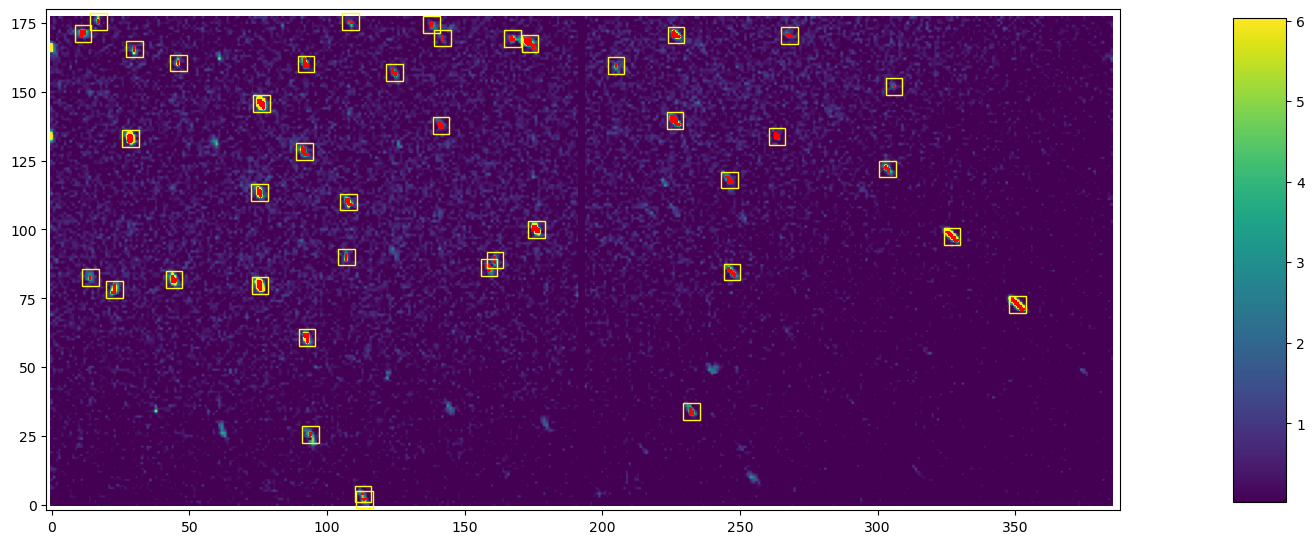

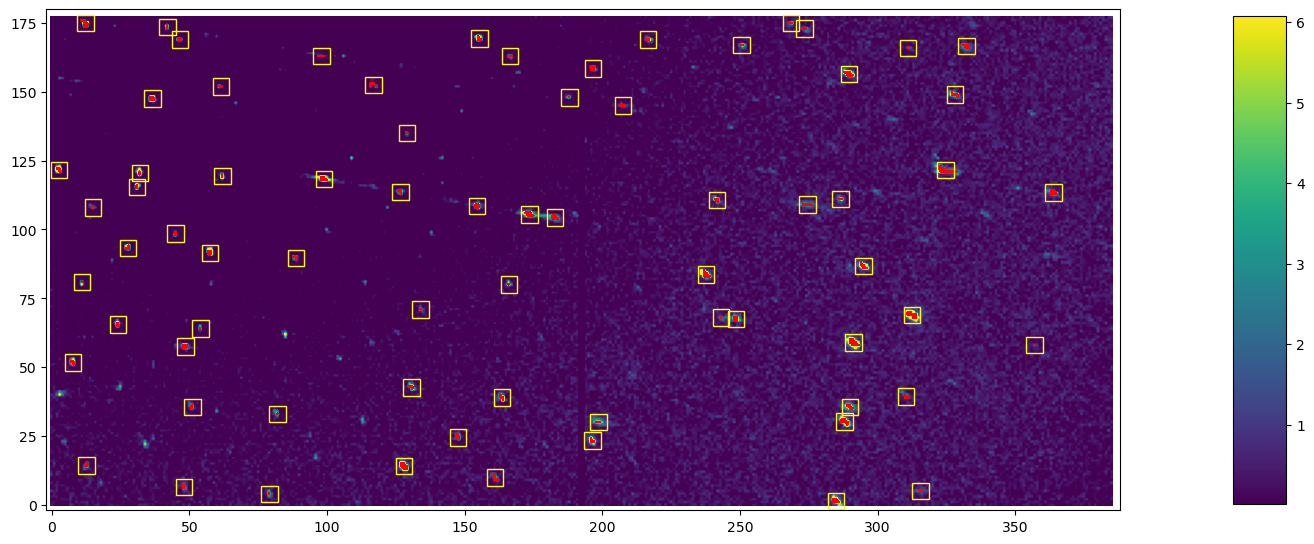

In [13]:
# Load images by event...
event = 46
multipanel_mask       = psana_img.create_bad_pixel_mask()
multipanel_img        = psana_img.get(event, None, 'calib')
multipanel_img_masked = multipanel_mask * multipanel_img

# Access multiple panels...
for idx_panel in range(len(multipanel_img_masked[:2])):
    img = torch.tensor(multipanel_img_masked[idx_panel]).type(dtype=torch.float)[None,None,].to(device)
    img = (img - img.mean()) / img.std()

    model.eval()
    with torch.no_grad():
        fmap = model.forward(img)
    mask_predicted = fmap.sigmoid()
    
    # threshold_prob = 1 - 1e-4
    threshold_prob = 0.7
    mask_predicted[  mask_predicted < threshold_prob ] = 0
    mask_predicted[~(mask_predicted < threshold_prob)] = 1
    
    # Crop the original image...
    size_y, size_x = mask_predicted.shape[-2:]
    img_crop, offset_tuple = center_crop(img, size_y, size_x, returns_offset_tuple = True)

    img_crop       = img_crop[0, 0].cpu().detach().numpy()
    mask_predicted = mask_predicted[0, 0].cpu().detach().numpy()
    
    
    # Locate peaks with coordinates...
    structure = np.ones((3, 3), dtype=bool)
    peak_predicted, num_peak_predicted = ndimage.label(cp.asarray(mask_predicted), structure)
    peak_pos_predicted_list = ndimage.center_of_mass(cp.asarray(mask_predicted), peak_predicted, cp.asarray(range(1, num_peak_predicted+1)))

    # [[[ Visual ]]]
    # Set up the visual
    ncols = 2
    nrows = 1
    fig   = plt.figure(figsize = (16,12))
    gspec = fig.add_gridspec( nrows, ncols,
                              width_ratios  = [1, 1/20],
                              height_ratios = [1,], 
                            )
    ax_list = [ fig.add_subplot(gspec[0, 0], aspect = 1),  
                fig.add_subplot(gspec[0, 1], aspect = 1.5), ]

    # Plot image
    data = img_crop
    vmin = data.mean()
    vmax = vmin + 6 * data.std()
    im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
    im.set_clim(vmin, vmax)
    plt.colorbar(im, cax = ax_list[1], orientation="vertical", pad = 0.05)

    # Plot mask overlay
    data = mask_predicted
    vmin = 0
    vmax = 1
    im2 = ax_list[0].imshow(data, vmin = vmin, vmax = vmax, alpha = 1.)
    im2.set_clim(vmin, vmax)
    cmap1 = mcolors.ListedColormap(['none', 'red'])
    im2.set_cmap(cmap1)
    
    # Place a box on a peak
    offset = 3
    b_offset = 2
    for y, x in peak_pos_predicted_list:
        if np.isnan(y) or np.isnan(x): continue

        x_bottom_left = x.get() - offset
        y_bottom_left = y.get() - offset

        rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                     2 * offset, 2 * offset, 
                                     linewidth = 1.0, 
                                     edgecolor = 'yellow', 
                                     facecolor='none')
        ax_list[0].add_patch(rec_obj)

        y_bmin, x_bmin = 0, 0
        y_bmax, x_bmax = size_y, size_x
        ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
        ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])

`%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% DIVIDER %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%`
<br/>
<br/>
<br/>
<br/>